Check running TensorFlow version

In [2]:
import tensorflow as tf
tf.__version__

'2.0.0-beta1'

Check devices that can be used by Tensorflow

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14042370417783920817
]


# Dogs vs. Cats

This is a continuation to the previous notebook. In this notebook I will try adding a regularizer (Dropout) and compare performance.

In [4]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

import matplotlib.pyplot as plt
%matplotlib inline

import random as rand

import numpy as np

In [5]:
batch_size = 16

## Prepare the dataset

I manually downloaded the dataset from this [Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats), unzipped it and here I will prepare for model training

In [6]:
data_path = Path("../data")
data_path.ls()

[PosixPath('../data/preprocessed'), PosixPath('../data/raw')]

In [7]:
dogs_vs_cats_dir_name = "dogs-vs-cats"
raw_dir_name = "raw"
preprocessed_dir_name = "preprocessed"

train_dir_name = "train"
valid_dir_name = "valid"
test_dir_name = "test"

dogs_dir_name = "dogs"
cats_dir_name = "cats"

raw_data_path = data_path/raw_dir_name/dogs_vs_cats_dir_name
preprocessed_data_path = data_path/preprocessed_dir_name/dogs_vs_cats_dir_name

dogs_train_data_path = preprocessed_data_path/train_dir_name/dogs_dir_name
cats_train_data_path = preprocessed_data_path/train_dir_name/cats_dir_name

dogs_valid_data_path = preprocessed_data_path/valid_dir_name/dogs_dir_name
cats_valid_data_path = preprocessed_data_path/valid_dir_name/cats_dir_name

dogs_test_data_path = preprocessed_data_path/test_dir_name/dogs_dir_name
cats_test_data_path = preprocessed_data_path/test_dir_name/cats_dir_name

## Build data generators

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    str(preprocessed_data_path/train_dir_name),
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

valid_generator = train_datagen.flow_from_directory(
    str(preprocessed_data_path/valid_dir_name),
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    str(preprocessed_data_path/test_dir_name),
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Check datagen outputs

## Train the model

In [8]:
train_generator[0][0].shape[1:]

(150, 150, 3)

In [9]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(.5))
model.add(layers.Dense(512))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

Check progress in TensorBoard by running `tensorboard --logdir=logs/dogs_vs_cats_v2` in terminal

In [10]:
# Try removing the old logs first
!rm -r ../logs/dogs_vs_cats_v2

callbacks = [
    keras.callbacks.TensorBoard(log_dir='../logs/dogs_vs_cats_v2')
]

In [11]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
steps_per_epoch = len(train_generator)
validation_steps = len(valid_generator)

steps_per_epoch, validation_steps

(125, 63)

In [13]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    callbacks=callbacks,
    validation_data=valid_generator,
    validation_steps=validation_steps,
)
history.history.keys()

Epoch 1/100


W0821 02:16:39.016561 139973957338880 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


  1/125 [..............................] - ETA: 11:45 - loss: 0.7084 - accuracy: 0.5000

W0821 02:16:44.245368 139973957338880 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.218315). Check your callbacks.


125/125 [==============================] - 31s 250ms/step - loss: 0.7628 - accuracy: 0.4975 - val_loss: 0.6914 - val_accuracy: 0.4980
Epoch 2/100
125/125 [==============================] - 17s 136ms/step - loss: 0.6964 - accuracy: 0.5035 - val_loss: 0.6900 - val_accuracy: 0.5250
Epoch 3/100
125/125 [==============================] - 17s 137ms/step - loss: 0.6872 - accuracy: 0.5350 - val_loss: 0.6869 - val_accuracy: 0.5940
Epoch 4/100
125/125 [==============================] - 17s 135ms/step - loss: 0.6909 - accuracy: 0.5420 - val_loss: 0.6727 - val_accuracy: 0.5960
Epoch 5/100
125/125 [==============================] - 17s 138ms/step - loss: 0.6970 - accuracy: 0.5670 - val_loss: 0.6756 - val_accuracy: 0.5990
Epoch 6/100
125/125 [==============================] - 17s 137ms/step - loss: 0.6830 - accuracy: 0.6010 - val_loss: 0.6623 - val_accuracy: 0.6050
Epoch 7/100
125/125 [==============================] - 17s 137ms/step - loss: 0.6817 - accuracy: 0.5985 - val_loss: 0.6434 - val_accurac

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

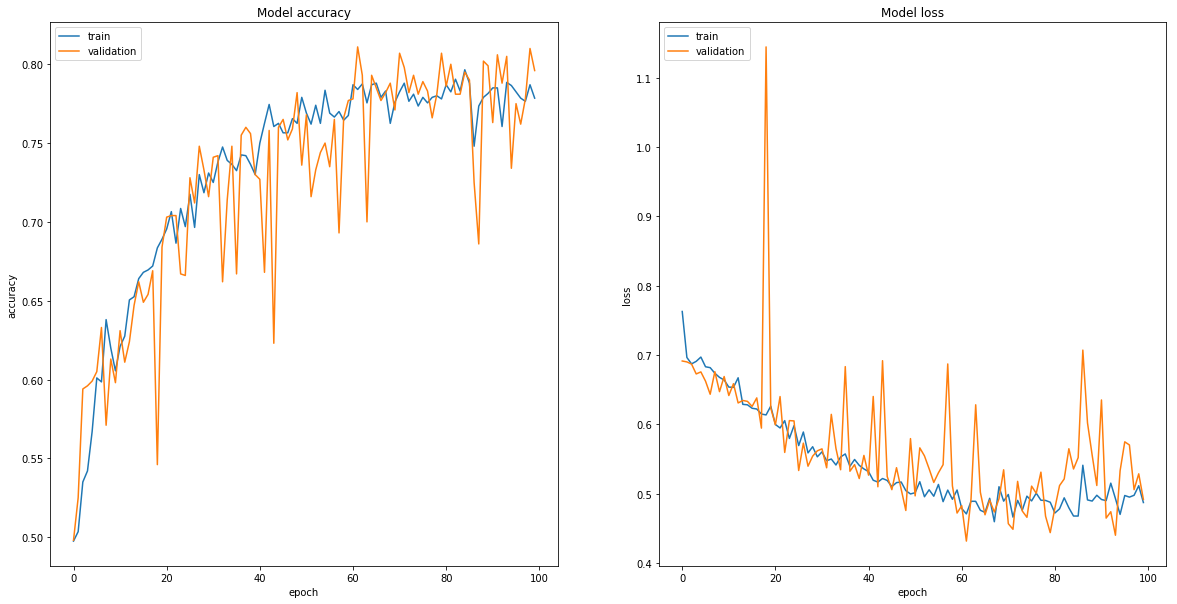

In [14]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

## Save the model

In [9]:
weights_path = Path("../weights")
weights_path.mkdir(parents=True, exist_ok=True)

In [17]:
model.save(str(weights_path/"dogs_vs_cats_v2.h5"))

## Evaluate

Load the saved model

In [10]:
model = keras.models.load_model(str(weights_path/"dogs_vs_cats_v2.h5"))

W0822 09:29:37.489082 4631422400 deprecation.py:323] From /Users/mostafagazar/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
model.trainable = False

# Compile model so changes to trainable would take effect
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [12]:
steps = len(test_generator)

loss, accuracy = model.evaluate_generator(
    test_generator,
    steps=steps
)
loss, accuracy

(0.525605013209676, 0.815)